# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# #Data Sets

The data is contained in three files:

portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
profile.json - demographic data for each customer
transcript.json - records for transactions, offers received, offers viewed, and offers completed
Here is the schema and explanation of each variable in the files:

portfolio.json

id (string) - offer id
offer_type (string) - type of offer ie BOGO, discount, informational
difficulty (int) - minimum required spend to complete an offer
reward (int) - reward given for completing an offer
duration (int) - time for offer to be open, in days
channels (list of strings)
profile.json

age (int) - age of the customer
became_member_on (int) - date when customer created an app account
gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
id (str) - customer id
income (float) - customer's income
transcript.json

event (str) - record description (ie transaction, offer received, offer viewed, etc.)
person (str) - customer id
time (int) - time in hours since start of test. The data begins at time t=0
value - (dict of strings) - either an offer id or transaction amount depending on the record
Note: If you are using the workspace, you will need to go to the terminal and run the command conda update pandas before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.

You can see how to access the terminal and how the install works using the two images below. First you need to access the terminal:



Then you will want to run the above command:



Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

First, we will import the necessary libraries

In [2]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score,classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

Now, we will take a closer look at the all the datasets

1) Portfolio:

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
print("Number of rows: ",portfolio.shape[0])
print("Number of columns: ",portfolio.shape[1])

Number of rows:  10
Number of columns:  6


In [5]:
portfolio['offer_type'].value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

In [6]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [7]:
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

2) Profile:

In [8]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [9]:
profile.dtypes

age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object

In [10]:
print("Number of rows: ",profile.shape[0])
print("Number of columns: ",profile.shape[1])

Number of rows:  17000
Number of columns:  5


In [11]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [12]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [13]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [14]:
print("Mean of income: ",profile['income'].mean())
print("Median of income: ",profile['income'].median())

Mean of income:  65404.9915683
Median of income:  64000.0


3) Transcript:

In [15]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [16]:
print("Number of rows: ",transcript.shape[0])
print("Number of columns: ",transcript.shape[1])

Number of rows:  306534
Number of columns:  4


In [17]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [18]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

# Exploratory Data Analysis

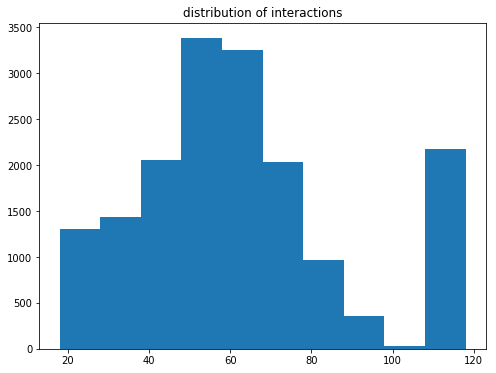

In [19]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(profile['age'])
ax.set_title('distribution of interactions')
plt.show();

There are several customers with 'age' around 115! They have to be removed

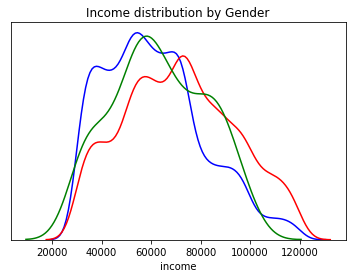

In [20]:
sns.distplot(profile[profile['gender']=='M']['income'],hist=False,color="b");
sns.distplot(profile[profile['gender']=='F']['income'],hist=False,color="r");
sns.distplot(profile[profile['gender']=='O']['income'],hist=False,color="g");
plt.title('Income distribution by Gender')
plt.gca().get_yaxis().set_visible(False)
plt.legend(['Male','Female','Other'],frameon=False);


# Data Preprocessing

First, the Portfolio DataFrame

There is a column for id in all three dataframes, lets change the names

In [21]:
portfolio.rename(columns={'id':'offer id'}, inplace=True)

There are four types of channels, lets create individual columns for them, and place 1 if it exist for that row and 0 if it doesn't

In [22]:
profile['Web'] = portfolio['channels'].apply(lambda i: 1 if 'web' in i else 0)
profile['Email'] = portfolio['channels'].apply(lambda i: 1 if 'email' in i else 0)
profile['Mobile'] = portfolio['channels'].apply(lambda i: 1 if 'mobile' in i else 0)
profile['Social'] = portfolio['channels'].apply(lambda i: 1 if 'social' in i else 0)

In [23]:
profile.isnull().sum()

age                     0
became_member_on        0
gender               2175
id                      0
income               2175
Web                 16990
Email               16990
Mobile              16990
Social              16990
dtype: int64

There are three types of offers, so we can create dummies for them, which will make it easy for later predictions

In [24]:
Offers = pd.get_dummies(portfolio['offer_type'])
portfolio = pd.concat([portfolio,Offers], axis=1)
portfolio.drop('offer_type',axis=1, inplace=True)
portfolio.head()

,channels,difficulty,duration,offer id,reward,bogo,discount,informational
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0


In [25]:
portfolio.columns

Index(['channels', 'difficulty', 'duration', 'offer id', 'reward', 'bogo',
       'discount', 'informational'],
      dtype='object')

First, lets convert the ages of 118 to NaN.
    

In [26]:
profile['age'] = profile['age'].apply(lambda i: np.nan if i ==118 else i)

In [27]:
profile.head(2)

,age,became_member_on,gender,id,income,Web,Email,Mobile,Social
0,NaN,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,0.0,1.0,1.0,1.0
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1.0,1.0,1.0,1.0


Next, change the Date format to %y%m%d format

In [28]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'],format='%Y%m%d')

In [29]:
t_date = pd.to_datetime(datetime.today().strftime('%Y%m%d'))
profile['became_member_on'] = (t_date - profile['became_member_on']) / np.timedelta64(1,'D') # timedelta(1,'D') is for day precision

Gender plays a major role in making conclusions for our project, so lets create dummies for them

In [30]:
Gender = pd.get_dummies(profile['gender'])

In [31]:
profile = pd.concat([profile,Gender], axis=1)

In [32]:
profile.rename(columns={'id':'customer_id'},inplace=True)

In [33]:
profile.head()

,age,became_member_on,gender,customer_id,income,Web,Email,Mobile,Social,F,M,O
0,NaN,1687.0,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,0.0,1.0,1.0,1.0,0,0,0
1,55.0,1534.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1.0,1.0,1.0,1.0,1,0,0
2,NaN,1172.0,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,1.0,1.0,1.0,0.0,0,0,0
3,75.0,1601.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1.0,1.0,1.0,0.0,1,0,0
4,NaN,1514.0,None,a03223e636434f42ac4c3df47e8bac43,NaN,1.0,1.0,0.0,0.0,0,0,0


As given in the prompt, id in profile represents customer_id, so we can change the name from 'id' to 'customer_id', for later

In [34]:
profile.rename(columns={'id':'customer_id'},inplace=True)

Next, the DataFrame Transcript

Now, for transcript DataFrame

In [35]:
transcript['offer_id'] = transcript['value'].apply(lambda i: i['offer_id'] if 'offer_id' in i else (i['offer id'] if 'offer id' in i else None))

We can create two seperate columns for reward and amount from 'value' column

In [36]:
for i in ['amount','reward']:
    transcript[i] = transcript['value'].apply(lambda x:x[i] if i in x else None)

In [37]:
transcript.drop('value',axis=1,inplace=True)

In [38]:
transcript.rename(columns={'person':'customer_id'},inplace=True)

We can take the successful offers, from 'event' column

In [39]:
transcript = transcript.groupby(['customer_id','offer_id','event'])['time'].count().unstack()

In [40]:
transcript.reset_index(level=[0,1],inplace = True)

In [41]:
transcript.fillna(0.0, inplace = True)

if the multiple of offer completed and offer viewed is greaters than 0, it can be considered as a successful offer, which can be denoted by 1, else 0

In [42]:
transcript['successful offer'] = transcript['offer completed'] * transcript['offer viewed']
    
transcript['successful offer'] = transcript['successful offer'].apply(lambda x: 1.0 if x > 0 else 0.0)
    
transcript.drop(['offer completed','offer viewed','offer received'],axis=1, inplace = True)

In [43]:
transcript.head()

event,customer_id,offer_id,successful offer
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0


In [44]:
transcript.rename(columns={'offer_id':'offer id'}, inplace=True)

In [45]:
transcript.head()

event,customer_id,offer id,successful offer
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0


Now, let's combine the three datasets we have 

We can merge the datasets, using a common column present in them.

For portfolio and transcript, 'offer_id' is a common column.

For profile and transcript, 'customer_id' is a common column.

In [46]:
def combine_dataset(portfolio, profile, transcript):
    """
    This function will combine the three datasets.
    Input: The three datasets we have.
    Output: A combined dataset.
    """
    df_combined = transcript.merge(portfolio,how='left',on='offer id')
    
    df_combined = df_combined.merge(profile,how='left',on='customer_id')
    
    
    return df_combined

df = combine_dataset(portfolio, profile, transcript)
df.head()

,customer_id,offer id,successful offer,channels,difficulty,duration,reward,bogo,discount,informational,...,became_member_on,gender,income,Web,Email,Mobile,Social,F,M,O
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0,"[web, email, mobile]",10,7,2,0,1,0,...,1619.0,M,72000.0,NaN,NaN,NaN,NaN,0,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,"[web, email, mobile]",0,4,0,0,0,1,...,1619.0,M,72000.0,NaN,NaN,NaN,NaN,0,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0,3,0,0,0,1,...,1619.0,M,72000.0,NaN,NaN,NaN,NaN,0,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,"[web, email, mobile, social]",5,5,5,1,0,0,...,1619.0,M,72000.0,NaN,NaN,NaN,NaN,0,1,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,"[web, email, mobile, social]",10,10,2,0,1,0,...,1619.0,M,72000.0,NaN,NaN,NaN,NaN,0,1,0


In [47]:
df.columns

Index(['customer_id', 'offer id', 'successful offer', 'channels', 'difficulty',
       'duration', 'reward', 'bogo', 'discount', 'informational', 'age',
       'became_member_on', 'gender', 'income', 'Web', 'Email', 'Mobile',
       'Social', 'F', 'M', 'O'],
      dtype='object')

In [48]:
df.dtypes

customer_id          object
offer id             object
successful offer    float64
channels             object
difficulty            int64
duration              int64
reward                int64
bogo                  uint8
discount              uint8
informational         uint8
age                 float64
became_member_on    float64
gender               object
income              float64
Web                 float64
Email               float64
Mobile              float64
Social              float64
F                     uint8
M                     uint8
O                     uint8
dtype: object

In [49]:
df['offer id'].value_counts()

0b1e1539f2cc45b7b9fa7c272da2e1d7    6374
ae264e3637204a6fb9bb56bc8210ddfd    6374
9b98b8c7a33c4b65b9aebfe6a799e6d9    6355
fafdcd668e3743c1bb461111dcafc2a4    6332
3f207df678b143eea3cee63160fa8bed    6331
4d5c57ea9a6940dd891ad53e9dbe8da0    6330
2298d6c36e964ae4a3e7e9706d1fb8c2    6325
5a8bc65990b245e5a138643cd4eb9837    6320
2906b810c7d4411798c6938adc9daaa5    6285
f19421c1d4aa40978ebb69ca19b0e20d    6262
Name: offer id, dtype: int64

In [50]:
unique = []
unique = list(df['offer id'].unique())
unique

['2906b810c7d4411798c6938adc9daaa5',
 '3f207df678b143eea3cee63160fa8bed',
 '5a8bc65990b245e5a138643cd4eb9837',
 'f19421c1d4aa40978ebb69ca19b0e20d',
 'fafdcd668e3743c1bb461111dcafc2a4',
 '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 '2298d6c36e964ae4a3e7e9706d1fb8c2',
 '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 '4d5c57ea9a6940dd891ad53e9dbe8da0',
 'ae264e3637204a6fb9bb56bc8210ddfd']

In [51]:
for i in range(len(unique)):
    df['offer id'] = df['offer id'].apply(lambda x: f' {i+1}' if x == unique[i] else x)
df.head()

,customer_id,offer id,successful offer,channels,difficulty,duration,reward,bogo,discount,informational,...,became_member_on,gender,income,Web,Email,Mobile,Social,F,M,O
0,0009655768c64bdeb2e877511632db8f,1,0.0,"[web, email, mobile]",10,7,2,0,1,0,...,1619.0,M,72000.0,NaN,NaN,NaN,NaN,0,1,0
1,0009655768c64bdeb2e877511632db8f,2,0.0,"[web, email, mobile]",0,4,0,0,0,1,...,1619.0,M,72000.0,NaN,NaN,NaN,NaN,0,1,0
2,0009655768c64bdeb2e877511632db8f,3,0.0,"[email, mobile, social]",0,3,0,0,0,1,...,1619.0,M,72000.0,NaN,NaN,NaN,NaN,0,1,0
3,0009655768c64bdeb2e877511632db8f,4,1.0,"[web, email, mobile, social]",5,5,5,1,0,0,...,1619.0,M,72000.0,NaN,NaN,NaN,NaN,0,1,0
4,0009655768c64bdeb2e877511632db8f,5,1.0,"[web, email, mobile, social]",10,10,2,0,1,0,...,1619.0,M,72000.0,NaN,NaN,NaN,NaN,0,1,0


Now, we can use data visualization for shortlisting. That is, we can see what age groups, gender, types of channels, etc, we can use to make the offers more profitable.

In [52]:
df.drop('gender',axis=1,inplace = True)

More visualizations..

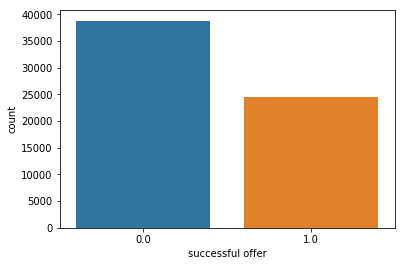

In [53]:
# Number of successful offers of the total
sns.countplot(df['successful offer'])

There is a big difference in successful and unsuccessful offers here, we will have to change this later.

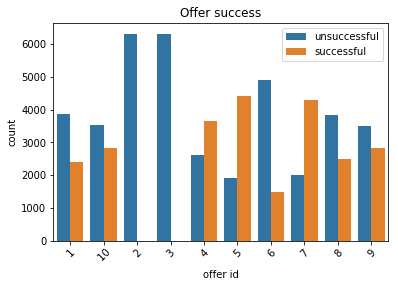

In [54]:
sns.countplot(x='offer id',hue='successful offer',data=df);
plt.legend(['unsuccessful','successful'])
plt.title('Offer success')

plt.xticks(rotation=45);

Order of influence for succesful offers:

1) offer 5 have the maximum successful offers, and the lease unsuccessful ones.

2) offer 7.

3) offer 4.

https://seaborn.pydata.org/generated/seaborn.distplot.html

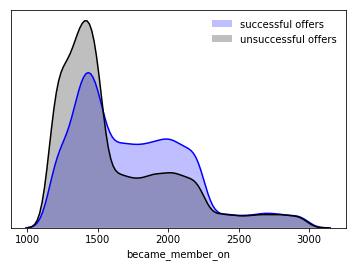

In [55]:
sns.distplot(df[df['successful offer']==1]['became_member_on'],hist=False,color='blue',kde_kws={'shade':True})
sns.distplot(df[df['successful offer']==0]['became_member_on'],hist=False,color='black',kde_kws={'shade':True})
plt.legend(['successful offers','unsuccessful offers'],frameon=False)
plt.gca().get_yaxis().set_visible(False);

This plot gives an overall distribution in successful offers, with the number of days a person has been a member, given by the column 'became_member_on'

# Modeling

We will try to predict if an offer is successful or not. We can do this using models which are accurate in predicting categorical variables. There are several predictive models for this, like Logistic Regression, SVM, Random foresr classifier, and many more. I am currently learning about the other models, hence I will be using the three mentioned above.

FIrst, lets create training and testing datasets from the combined dataset we have

In [56]:
df.columns

Index(['customer_id', 'offer id', 'successful offer', 'channels', 'difficulty',
       'duration', 'reward', 'bogo', 'discount', 'informational', 'age',
       'became_member_on', 'income', 'Web', 'Email', 'Mobile', 'Social', 'F',
       'M', 'O'],
      dtype='object')

In [57]:
df.drop('channels',axis=1,inplace = True)

In [58]:
df['income'].isnull().sum()

8066

In [59]:
df['age'].isnull().sum()

8066

In [60]:
df.isnull().sum()

customer_id             0
offer id                0
successful offer        0
difficulty              0
duration                0
reward                  0
bogo                    0
discount                0
informational           0
age                  8066
became_member_on        0
income               8066
Web                 63252
Email               63252
Mobile              63252
Social              63252
F                       0
M                       0
O                       0
dtype: int64

These two columns have a lot of NaN values, we can fill them

In [61]:
def df_preperation(df):
    '''
    Function to clean overall_df to return X variables and the predictor Y
    
    Input - overall_df
    
    output - two dataframes X and Y
    
    X - Will be all the variables we will be using to predict the best offer type.
    
    Y - Will be the offer type.
    
    '''
    
    #We want to look at only successful offers
    
    temp_df = df.loc[df['successful offer'] == 1]
    

    
    for i in ['age','income','Web','Email','Mobile','Social']:
        
        temp_df[i] = temp_df[i].fillna(temp_df[i].mean())
    
    
    
    
    X =temp_df.iloc[:,3:]
    
    y=temp_df.iloc[:,1]
    
    
    return X, y

X,y = df_preperation(df)
    

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [62]:
X.shape, y.shape

((24460, 16), (24460,))

In [63]:
X.isnull().sum()

difficulty          0
duration            0
reward              0
bogo                0
discount            0
informational       0
age                 0
became_member_on    0
income              0
Web                 0
Email               0
Mobile              0
Social              0
F                   0
M                   0
O                   0
dtype: int64

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25,random_state=21)
X_train.shape,X_test.shape

((18345, 16), (6115, 16))

In [65]:
sc = StandardScaler()
X_train=sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

https://www.datasciencelearner.com/how-to-choose-n_estimators-in-random-forest/

In [66]:
clf = RandomForestClassifier(n_estimators=10,criterion='gini',random_state=54)

clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=54, verbose=0, warm_start=False)

In [67]:
y_pred = clf.predict(X_test)

In [68]:
rf_accuracy = accuracy_score(y_test,y_pred)
rf_accuracy

1.0

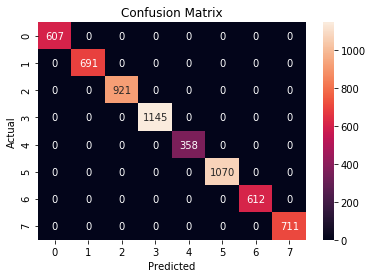

In [69]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.ylabel("Actual")
plt.xlabel("Predicted");

Since the accuracy is very high, we cannot rely on this algorithm. 

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/

In [70]:
df_class1 = df.loc[df['successful offer']==1]

In [71]:
# class count
class_count_0, class_count_1 = df['successful offer'].value_counts()

# Separate class
df_class1_over = df_class1.sample(class_count_0,replace=True)
df_class_0 = df.loc[df['successful offer'] == 0]
new_df = pd.concat([df_class1_over,df_class_0],axis=0)

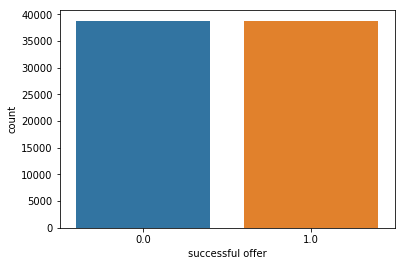

In [72]:
sns.countplot(new_df['successful offer'])

In [73]:
new_df.isnull().sum()

customer_id             0
offer id                0
successful offer        0
difficulty              0
duration                0
reward                  0
bogo                    0
discount                0
informational           0
age                  8643
became_member_on        0
income               8643
Web                 77625
Email               77625
Mobile              77625
Social              77625
F                       0
M                       0
O                       0
dtype: int64

In [74]:
for col in ['age','income','Web','Email','Mobile','Social']:
    new_df[col] = new_df[col].fillna(new_df[col].median())

In [75]:
X = new_df.iloc[:,3:]
y = new_df.iloc[:,2]

In [76]:
X = pd.concat([X, new_df['offer id']],axis=1)

In [77]:
X = X.drop(['Email'],axis=1)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25, shuffle=True, random_state = 42)

In [79]:
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [80]:
model = LogisticRegression()

In [81]:
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [82]:
y_pred_rf = model.predict(X_test)

In [83]:
accuracy = accuracy_score(y_test,y_pred_rf)
accuracy

0.7027402905120016

https://towardsdatascience.com/supervised-machine-learning-model-validation-a-step-by-step-approach-771109ae0253

In [84]:
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression

# Create pipeline
pipeline = make_pipeline(\
                         RobustScaler(),
                         SelectKBest(f_classif),
                         LogisticRegression(solver='lbfgs'))

In [85]:
# Model validation.
from sklearn.model_selection import GridSearchCV

param_grid = {
    'selectkbest__k': [1, 2, 3, 4],
    'logisticregression__class_weight': [None,'balanced'],
    'logisticregression__C': [.0001, .001, .01, .1, 1.0, 10.0, 100.00, 1000.0, 10000.0]
}

gridsearch = GridSearchCV(pipeline, param_grid=param_grid, cv=5,
                         scoring='accuracy', verbose=1)

gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  1.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('selectkbest', SelectKBest(k=10, score_func=<function f_classif at 0x7fa112c06620>)), ('logisticregression', LogisticRegression(C=1.0, c...nalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'selectkbest__k': [1, 2, 3, 4], 'logisticregression__class_weight': [None, 'balanced'], 'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [86]:
#Get the best model and check it against test data set.

# Predict with X_test features
y_pred = gridsearch.predict(X_test)

# Compare predictions to y_test labels
test_score = accuracy_score(y_test, y_pred)
print('Accuracy Score on test data set:', test_score)

Accuracy Score on test data set: 0.663747810858


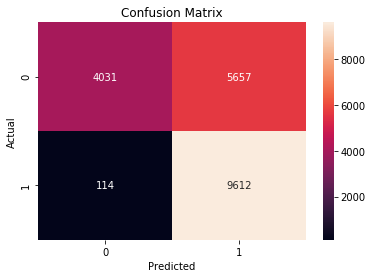

In [87]:
sns.heatmap(confusion_matrix(y_test,y_pred_rf),annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.ylabel("Actual")
plt.xlabel("Predicted");

SVM

In [88]:
from sklearn import svm
from sklearn.svm import SVC

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25,random_state=42)

In [90]:
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [91]:
clf = SVC(decision_function_shape='ovo')

In [92]:
clf.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [93]:
y_pred_svm = clf.predict(X_test)

In [94]:
svc_accuracy = accuracy_score(y_test,y_pred_svm)
svc_accuracy

0.75620686102812407

In [95]:
svc_f1 = f1_score(y_test,y_pred_svm)
svc_f1

0.75724470431348412

In [96]:
print(classification_report(y_test,y_pred_svm))

             precision    recall  f1-score   support

        0.0       0.76      0.75      0.76      9688
        1.0       0.76      0.76      0.76      9726

avg / total       0.76      0.76      0.76     19414



In [97]:
svc_model = SVC(C=1,gamma=1,kernel='rbf')

svc_model.fit(X_train,y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [98]:
y_pred_svc_2 = svc_model.predict(X_test)
svc2_accuracy = accuracy_score(y_test,y_pred_svc_2)
svc2_f1 = f1_score(y_test,y_pred_svc_2)

In [99]:
print('Accuracy for SVM with RBF Kernel: %.3f' % svc2_accuracy)
print('F1 score for SVM with RBF Kernel: %.3f' % svc2_f1)

Accuracy for SVM with RBF Kernel: 0.765
F1 score for SVM with RBF Kernel: 0.769


In [100]:
print(classification_report(y_test,y_pred_svc_2))

             precision    recall  f1-score   support

        0.0       0.77      0.75      0.76      9688
        1.0       0.76      0.78      0.77      9726

avg / total       0.77      0.77      0.77     19414



In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred_svm),annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.ylabel("Actual")
plt.xlabel("Predicted");

From the above, we can say that SVM is the most accurate model of the three we have used here.

In [101]:
metrics = np.array([rf_accuracy,accuracy,svc_accuracy]).reshape(-1,1)

In [102]:
metrics = pd.DataFrame(metrics)

In [103]:
model_names = np.array(['Random Forest Classifier','Logistic Regression', 'Support Vector Machine']).reshape(-1,1)

In [104]:
metrics = pd.concat([metrics,pd.DataFrame(model_names)],axis=1)

In [105]:
metrics.columns = ['Accuracy','Model Names']

In [106]:
metrics.set_index('Model Names').sort_values(by='Accuracy',ascending=False)

,Accuracy
Model Names,
Random Forest Classifier,1.000000
Support Vector Machine,0.756207
Logistic Regression,0.702740


# Conclusions

From the exploratory data analysis, we concluded:

Relationship between age and number of interactions:

Maximum number of people interacted are between the age of 50-70.
We can increase the number of interactions with that age group and make them a target audience. People near 40 have also ineracted a lot, they should also be considered.

Offer number 5, 7 and 4 are the ost successful successful ones. 

Offer 1 and 2 are the least.

We saw the difference in the income, based on the gender.

I have selected three predictive models

1) Random Forest Classifier.

2) Logistic Regression.

3) Support Vector Machines(SVM)

We can use other models as well, but I am using these three as I am currently familiar with them.

Out of the three, we got the following observations:

1) Random Forrest:
   
   The accuracy score we got was 1, which means 100% accuracy. This is not possible in any model we use. This may have happened due to the presence of duplicates in both train and test datasets.

2) Logistic Regression:

   Logistic regression is one of the best models to use in predicting categorical values. In this case, the accuracy was 71%. We can do better than this with other models.

3) Support vector machine:
    
    In this case, the accuracy was 76%. This has given the best result out of the three.